In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import JacobiKAN
from kans.utils import create_dataset

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# Generate dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
print('train_input size:', dataset['train_input'].shape)
print('train_label',dataset['train_label'].shape)
print('test_input size:', dataset['test_input'].shape)
print('test_label',dataset['test_label'].shape)

# Create data loader
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_input size: torch.Size([1000, 2])
train_label torch.Size([1000, 1])
test_input size: torch.Size([1000, 2])
test_label torch.Size([1000, 1])


In [3]:
# Create model
layer_sizes = [2,5,3,1]  # Specify the number of nodes per layer
alpha = 0.5
beta = 0.5
order = 5
model = JacobiKAN(layer_sizes, order, alpha, beta)
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [4]:
# Training process
num_epochs = 50
epoch_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss
        running_loss += loss.item()
        
        # Print information every certain steps
        # if (i + 1) % 10 == 0:
            # print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Print average loss every epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed. Average Loss: {epoch_loss:.4f}")
    epoch_losses.append(epoch_loss)

# Save the model
torch.save(model.state_dict(), 'model/jacobi_kan_model.pth')

Epoch [1/50] completed. Average Loss: 3.1547
Epoch [2/50] completed. Average Loss: 0.6256
Epoch [3/50] completed. Average Loss: 0.1259
Epoch [4/50] completed. Average Loss: 0.0473
Epoch [5/50] completed. Average Loss: 0.0389
Epoch [6/50] completed. Average Loss: 0.0266
Epoch [7/50] completed. Average Loss: 0.0362
Epoch [8/50] completed. Average Loss: 0.0180
Epoch [9/50] completed. Average Loss: 0.0080
Epoch [10/50] completed. Average Loss: 0.0075
Epoch [11/50] completed. Average Loss: 0.0065
Epoch [12/50] completed. Average Loss: 0.0086
Epoch [13/50] completed. Average Loss: 0.0086
Epoch [14/50] completed. Average Loss: 0.0049
Epoch [15/50] completed. Average Loss: 0.0063
Epoch [16/50] completed. Average Loss: 0.0035
Epoch [17/50] completed. Average Loss: 0.0045
Epoch [18/50] completed. Average Loss: 0.0088
Epoch [19/50] completed. Average Loss: 0.0044
Epoch [20/50] completed. Average Loss: 0.0037
Epoch [21/50] completed. Average Loss: 0.0191
Epoch [22/50] completed. Average Loss: 0.02

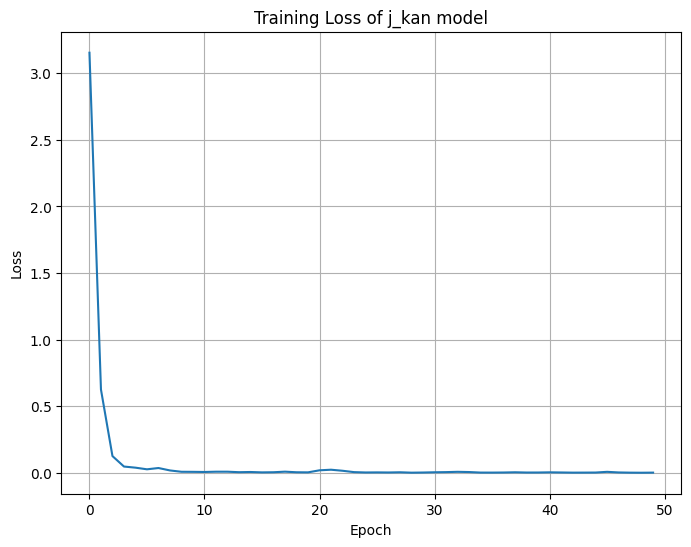

In [5]:
# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of j_kan model')
plt.grid(True)
plt.show()

In [6]:
# Load the model
model = JacobiKAN(layer_sizes, order, alpha, beta)
model.load_state_dict(torch.load('model/jacobi_kan_model.pth'))

<All keys matched successfully>

In [7]:
# Test the model
model.eval()
test_input = dataset['test_input']
test_label = dataset['test_label']
with torch.no_grad():
	test_output = model(test_input)
test_loss = criterion(test_output, test_label).item()
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0026
